In [1]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

load_dotenv()

model = ChatOpenAI(model="gpt-5")

In [2]:
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]

memory = MemorySaver()

In [3]:
llm_with_tools = model.bind_tools(tools=tools)

In [4]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result],
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END

async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls

    # Initialize list to store tool messages
    tool_messages = []

    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)

            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )

            tool_messages.append(tool_message)

    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

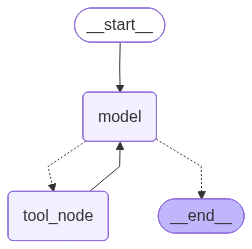

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [6]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")],
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='f993cf0e-f6bb-4669-a7ae-c9d7e7fda375'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HXVySKPAzJtwbsQYDmJNZbFZ', 'function': {'arguments': '{"query": "next SpaceX launch"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_GZ29jNNzB7YZVjzkHsp73WNW', 'function': {'arguments': '{"query": "SpaceX launch schedule official site"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_ITs1xOwH8kYNWESzDeoxC38b', 'function': {'arguments': '{"query": "NextSpaceflight SpaceX upcoming launches"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 349, 'prompt_tokens': 168, 'total_tokens': 517, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0

In [7]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end='', flush=True)

The next SpaceX launch is a Starlink mission on Falcon 9 from Vandenberg SFB (SLC-4E), currently targeting Saturday, December 13, 2025, with a window from 05:34–09:34 UTC (Friday, Dec 12, 9:34 pm–1:34 am PST).

Source: SpaceX launch schedule — https://www.spacex.com/launches
Times are subject to change; check the link close to launch. If you share your time zone, I can convert the window for you.